# Sandbox - Generate Data

This notebook is used to prototype the generate_data function, used to generate all scenarios of use of the algorithm.

---

## Imports & Config

In [1]:
! pwd

/Users/simonlejoly/Documents/Work/mimosa/tests


In [2]:
! export XLA_PYTHON_CLIENT_MEM_FRACTION=.25

In [3]:
# Jax configuration
USE_JIT = False
USE_X64 = True
DEBUG_NANS = False
VERBOSE = False

In [4]:
# Standard library imports
import os
os.environ['JAX_ENABLE_X64'] = str(USE_X64).lower()

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

from typing import Tuple

In [5]:
# Third party
import jax
jax.config.update("jax_disable_jit", not USE_JIT)
jax.config.update("jax_debug_nans", DEBUG_NANS)
import jax.random as jr
import jax.numpy as jnp
import jax.scipy as jsp
from jax import vmap, jit, Array
from jax.tree_util import tree_map_with_path, GetAttrKey, tree_unflatten, tree_flatten

import matplotlib.pyplot as plt
import equinox as eqx
from equinox import filter_jit
import numpy as np

from kernax import WhiteNoiseKernel, VarianceKernel, AbstractKernel, SEKernel, AbstractMean, AffineMean

In [6]:
# Local imports
from mimosa.linalg import scatter_to_grid_1d, scatter_to_grid_2d, cho_factor, cho_solve
from mimosa.generate_data import generate_data

INFO:2026-02-27 15:42:32,182:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/mimosa/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2026-02-27 15:42:32,182 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/mimosa/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


In [7]:
# Config
key = jr.PRNGKey(42)

T=99 ; K=3 ; F=1 ; N=25 ; I=1 ; O=2 ; gs=100 if I == 1 else 40

sth=True ; sch=False ; chit=True ; fh=False ; soh=False ; siit=True ; siif=True

mean = AffineMean(slope=0., intercept=0.)
mean_kernel = VarianceKernel(20.) * SEKernel(length_scale=10.)
task_kernel = VarianceKernel(.2) * SEKernel(length_scale=9.) + WhiteNoiseKernel(noise=.01)

mean_priors = {
	"slope": (-.2, .2),
	"intercept": (-2.5, 2.5)
}

mean_kernel_priors = {
	"variance": (5, 10.),
	"length_scale": (2.5, 10.)
}

task_kernel_priors = {
	"variance": (0.25, 1.),
	"length_scale": (2., 8.),
	"noise": (0.01, 0.1)
}

jax.devices()

[CpuDevice(id=0)]

In [8]:
inputs, outputs, maps, grid, m_p_means, m_p_covs, m_p, mix, t_m, m, m_k, t_k = generate_data(key, T, K, F, N,  I, O, gs, mean, mean_kernel, task_kernel, mean_priors, mean_kernel_priors, task_kernel_priors, sth, sch, chit, fh, soh, siit, siif)

---

## Hyperpost

In [9]:
from typing import Tuple

# Third party
import jax.numpy as jnp
from jax import jit, Array

from kernax import AbstractKernel, AbstractMean

# Local imports
from mimosa.linalg import scatter_to_grid_1d, scatter_to_grid_2d, cho_factor, cho_solve


# General function
@jit
def hyperpost(inputs: Array, outputs: Array, mappings: Array, grid: Array, mixture_coeffs: Array,
              mean_func: AbstractMean, mean_kernel: AbstractKernel, task_kernel: AbstractKernel) -> Tuple[Array, Array]:
	"""
	Computes the posterior mean and covariance of a Magma GP given the inputs, outputs, mappings, prior mean and kernels.

	:param inputs: Input points. Shape (F*N, I) if shared_inputs_in_tasks, else (T, F*N, I)
	:param outputs: Outputs points. Shape (T, F*N, O)
	:param mappings: Indices of each input in the grid, padded with len(grid). Shape (T, F*N)
	:param grid: points on which to compute the posterior. Shape (F*G, I)
	:param mixture_coeffs: mixture coefficients for every task. Shape(T, K)
	:param mean_func: Mean function to compute the prior mean of each process. Should accept the grid as input.
	:param mean_kernel: Kernel to be used to compute the mean covariance. Should accept the grid as input.
	:param task_kernel: Kernel to be used to compute the task covariance. Should accept the inputs as input.

	:return: a 2-tuple of the posterior mean and covariance
	"""
	big_eye = jnp.eye(grid.shape[0])
	small_eye = jnp.eye(inputs.shape[-2])

	mean_process_covs = mean_kernel(grid)  # Shape (K, O, F*G, F*G) with K=1 if shared_cluster_hps and O=1 if shared_output_hps

	# Compute mean covariance and its Cholesky factor
	mean_covs_u = cho_factor(mean_process_covs)  # Same shape
	mean_covs_inv = cho_solve(mean_covs_u, jnp.broadcast_to(big_eye, mean_covs_u.shape))  # Same shape

	# Compute task covariance, its Cholesky factor and mask NaNs with identity rows/cols
	task_covs = task_kernel(inputs)  # Shape: (T, K, O, F*N, F*N) with K=1 if shared_cluster_hps and O=1 if shared_output_hps
	eyed_task_covs = jnp.where(jnp.isnan(task_covs), small_eye, task_covs)

	# --- Posterior covariance ---
	# Small task covs
	task_covs_U = cho_factor(eyed_task_covs) # Shape: (T, K, O, F*N, F*N)
	task_covs_inv = cho_solve(task_covs_U, jnp.broadcast_to(small_eye, task_covs_U.shape))  # Same shape
	task_covs_inv -= jnp.where(jnp.isnan(task_covs), small_eye, 0)  # Correction on the diagonal
	task_covs_inv *= mixture_coeffs[:, :, None, None, None]  # Apply mixture coefficients

	# Map to full grid and sum over tasks
	task_covs_inv = scatter_to_grid_2d(jnp.full((len(grid), len(grid)), jnp.nan), task_covs_inv, mappings)  # Shape (T, K, O, F*G, F*G)
	task_covs_inv = jnp.nan_to_num(task_covs_inv).sum(axis=0)  # Shape (K, O, F*G, F*G)

	# Sum mean and task covariances and compute Cholesky factor of the posterior covariance
	post_covs_inv = cho_factor(mean_covs_inv + task_covs_inv)  # Shape (K, O, F*G, F*G)
	post_covs = cho_solve(post_covs_inv, jnp.broadcast_to(big_eye, post_covs_inv.shape))  # Shape (K, O, F*G, F*G)

	# --- Posterior mean ---
	# Compute prior means
	prior_means = mean_func(grid)  # Shape (K, O, F*G) with K=1 if shared_cluster_hps and O=1 if shared_output_hps
	prior_means = cho_solve(mean_covs_u, prior_means)  # Same shape

	# Compute weighted tasks
	outputs = outputs[:, None, :, :].swapaxes(-1, -2)  # Shape (T, 1, O, F*N)
	if task_covs_U.shape[1] != 1:  # If not shared_cluster_hps, we need to broadcast outputs
		outputs = jnp.broadcast_to(outputs, (outputs.shape[0], task_covs_U.shape[1]) + outputs.shape[2:])  # Shape (T, K, O, F*N)

	task_means = cho_solve(jnp.broadcast_to(task_covs_U, outputs.shape+(task_covs_U.shape[-1],)), outputs) # Shape (T, K, O, F*N) with K=1 if shared_cluster_hps
	task_means *= mixture_coeffs[:, :, None, None]  # Shape (T, K, O, F*N)
	task_means = scatter_to_grid_1d(jnp.full((len(grid),), 0.), task_means, mappings).sum(axis=0)  # Shape (K, O, F*G)

	full_means = jnp.broadcast_to(prior_means, task_means.shape) + task_means  # Shape (K, O, F*G)
	post_means = cho_solve(jnp.broadcast_to(post_covs_inv, full_means.shape + (post_covs_inv.shape[-1],)), full_means)

	return post_means, post_covs

In [10]:
mix_coeffs = jnp.eye(K)[mix]
mix_coeffs.shape

(99, 3)

In [11]:
maps.shape

(25,)

In [12]:
p_m, p_c = hyperpost(inputs, outputs, maps, grid, mix_coeffs, m, m_k, t_k)
p_m.shape, p_c.shape

((3, 2, 100), (3, 2, 100, 100))

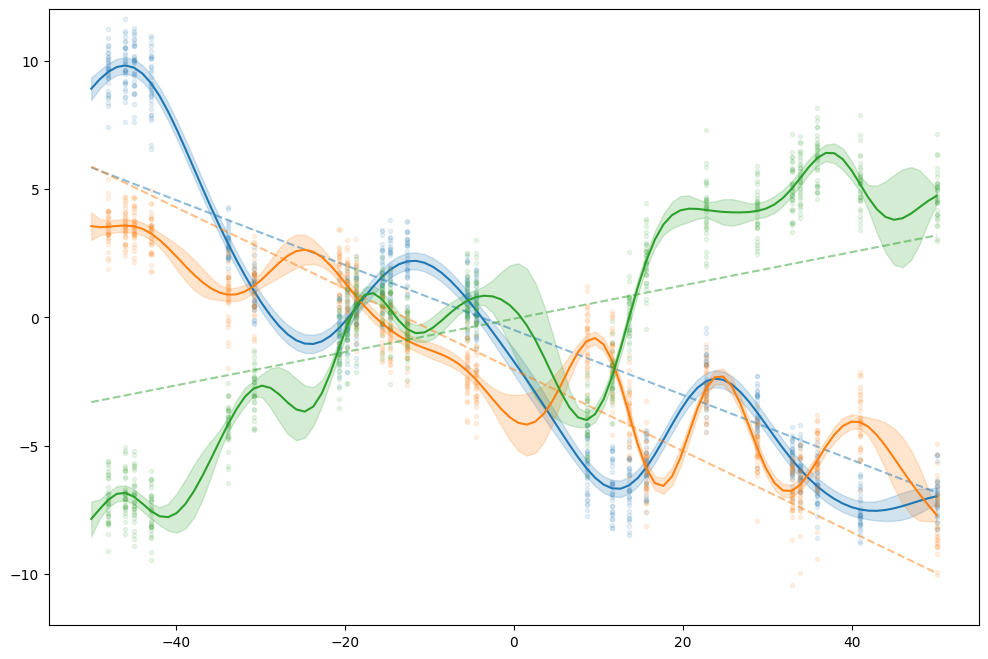

In [13]:
o_i = 1
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(range(K))
for k_i in range(K):
	# Print the hyper-prior
	plt.plot(grid[:, 0], m(grid)[k_i, o_i, :], color=colors[k_i], linestyle='--', alpha=.5)

	# Print the post-mean of the mean process
	plt.plot(grid[:, 0], p_m[k_i, o_i, :], color=colors[k_i])

	# Print the confidence interval of the post-covariance of the mean process
	std = jnp.sqrt(jnp.diagonal(p_c[k_i, o_i, :, :]))
	plt.fill_between(grid[:, 0], p_m[k_i, o_i, :] - 1.98*std, p_m[k_i, o_i, :] + 1.98*std, color=colors[k_i], alpha=0.2)

	# Print the tasks that belong to this cluster as points
	if siit:
		for t_i in range(len(outputs[mix == k_i])):
			plt.plot(inputs[:, 0], outputs[mix == k_i][t_i, :, o_i], marker='.', linestyle='None', color=colors[k_i], alpha=0.1)
	else:
		for t_i in range(len(inputs[mix == k_i])):
			plt.plot(inputs[mix == k_i][t_i, :, 0], outputs[mix == k_i][t_i, :, o_i], marker='.', linestyle='None', color=colors[k_i], alpha=0.1)

plt.xlim(-55, 55)
plt.ylim(-12, 12)
plt.show()

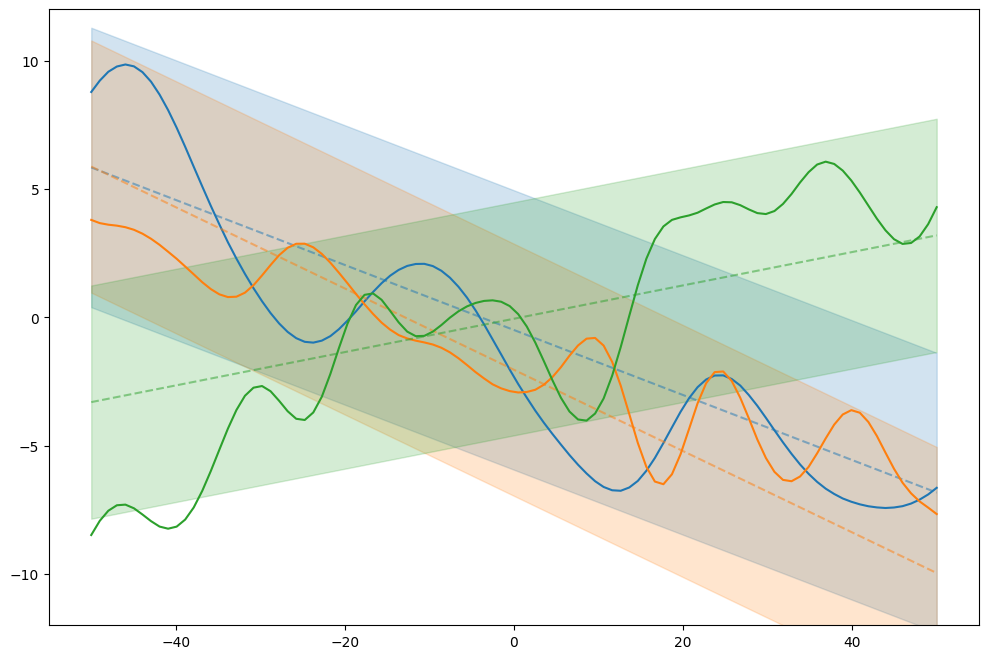

In [14]:
o_i = 1
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(range(K))
for k_i in range(K):
	# Print the hyper-prior
	plt.plot(grid[:, 0], m(grid)[k_i, o_i, :], color=colors[k_i], linestyle='--', alpha=.5)

	# Print the post-mean of the mean process
	plt.plot(grid[:, 0], m_p[k_i, o_i, :], color=colors[k_i])

	# Print the confidence interval of the post-covariance of the mean process
	std = jnp.sqrt(jnp.diagonal(m_p_covs[k_i, o_i, :, :]))
	plt.fill_between(grid[:, 0], m_p_means[k_i, o_i, :] - 1.98*std, m_p_means[k_i, o_i, :] + 1.98*std, color=colors[k_i], alpha=0.2)

	"""
	# Print the tasks that belong to this cluster as points
	if siit:
		for t_i in range(len(outputs[mix == k_i])):
			plt.plot(inputs[:, 0], outputs[mix == k_i][t_i, :, o_i], marker='.', linestyle='None', color=colors[k_i], alpha=0.1)
	else:
		for t_i in range(len(inputs[mix == k_i])):
			plt.plot(inputs[mix == k_i][t_i, :, 0], outputs[mix == k_i][t_i, :, o_i], marker='.', linestyle='None', color=colors[k_i], alpha=0.1)
		"""
plt.xlim(-55, 55)
plt.ylim(-12, 12)
plt.show()

In [25]:
jnp.sqrt(m_p_covs[0, 0, 0, 0])

Array(2.37743171, dtype=float64)

In [20]:
print(m_k)

VarianceKernel(variance=[6.60 ± 1.22]₃ₓ₂) * SEKernel(length_scale=[6.06 ± 1.91]₃ₓ₂)


In [27]:
jnp.sqrt(m_k.inner.inner.left.variance[0, 0])

Array(2.37743171, dtype=float64)

---

## Sandbox

---